<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

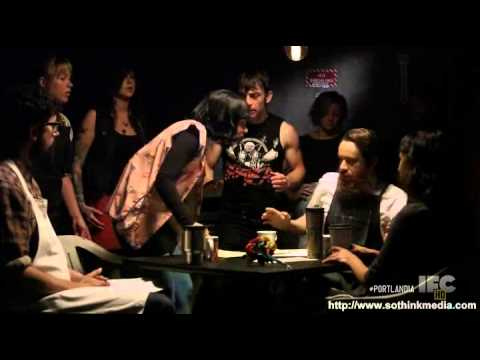

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [1]:
%pwd

'/home/j_m/documents/github/DS-Unit-4-Sprint-1-NLP/module1-text-data'

### Imports

In [1]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd
import datetime as dt

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

### Load dataframe

In [2]:
url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


## Wrangle dataframe

In [3]:
shops['star_rating'] = shops['star_rating'].str.replace('star rating','').astype(float)

review_text = shops['full_review_text'].apply(lambda x: x.split())

shops = shops.drop(columns = ['full_review_text'])

date_list = [review_text[ii][0] for ii in range(len(review_text))]

shops['review_date'] = pd.Series(date_list)

review_text_nlp = [nlp(re.sub('[^A-Za-z ]+', '', 
                                " ".join(review_text[ii][1:]))
                            .strip().lower())
                      for ii in range(shops.shape[0])]

shops['review_redo'] = pd.Series(review_text_nlp)

for row in range(shops['review_redo'].shape[0]):
    shops['review_redo'][row] = " ".join([token.lemma_ for token in shops['review_redo'][row]])
    
    
sub_list = ['   ', '  ']

for char in sub_list:
    shops['review_redo'] = [re.sub(char, ' ', shops['review_redo'][ii])  
                            for ii in range(shops.shape[0])]
    
    
shops.head()

/home/j_m/.local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,coffee_shop_name,star_rating,review_date,review_redo
0,The Factory - Cafe With a Soul,5.0,11/25/2016,checkin love love love the atmosphere every co...
1,The Factory - Cafe With a Soul,4.0,12/2/2016,list in date night austin ambiance in austin b...
2,The Factory - Cafe With a Soul,4.0,11/30/2016,checkin list in brunch spot i love the eclecti...
3,The Factory - Cafe With a Soul,2.0,11/25/2016,very cool decor good drink nice seating howeve...
4,The Factory - Cafe With a Soul,4.0,12/3/2016,checkin -PRON- be locate within the northcross...


### Load custom functions

In [4]:
def make_tokens(df_feature):
    
    """
    Input: Column of a dataframe/ Pandas Series
    
    Output: List consisting of tokens for each observation
    """
    
    tokens = []
    tokenizer = Tokenizer(nlp.vocab)

    STOP_WORDS = nlp.Defaults.stop_words.union(['coffee','place', 'im', 's', 'shop',
                                                'ive', 'checkin', 'checkins', 'austin', 
                                                'work', 'got', 'told', 'cafe', '-PRON-',
                                               'ordered','know', 'youre', 'review', 'said'])

    for doc in tokenizer.pipe(df_feature, batch_size=500):

        doc_tokens = []

        for token in doc: 
            if token.text not in STOP_WORDS:
                doc_tokens.append(token.text.lower())

        tokens.append(doc_tokens)

    return tokens

In [6]:
def count(docs):
    """
    Input: Series of spacy docs objects / dataframe column
    
    Output: Pandas dataframe consisting of words and their 
    stats based on how many times they appear in the series
    """
    word_counts = Counter()
    appears_in = Counter()
       
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())
        
    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
    return wc.sort_values(by='rank')

In [7]:
shops['tokens'] = make_tokens(shops['review_redo'])

In [8]:
wc = count(shops['tokens'])
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
141,good,3597,5399,1.0,0.017298,0.017298,0.472295
92,great,2853,3946,2.0,0.012643,0.029941,0.374606
149,like,2260,3350,3.0,0.010733,0.040674,0.296744
367,come,1931,2632,4.0,0.008433,0.049107,0.253545
7,love,1818,2374,5.0,0.007606,0.056713,0.238708


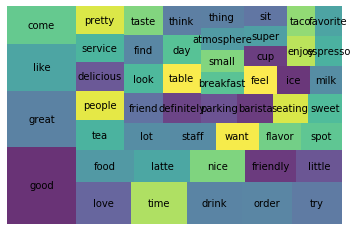

In [9]:
wc_top50 = wc[wc['rank'] <= 50]

squarify.plot(sizes=wc_top50['pct_total'], label=wc_top50['word'], alpha=.8 )
plt.axis('off')
plt.show()

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [10]:
shops['star_rating'].value_counts(normalize = True)

5.0    0.496324
4.0    0.309874
3.0    0.096901
2.0    0.060399
1.0    0.036502
Name: star_rating, dtype: float64

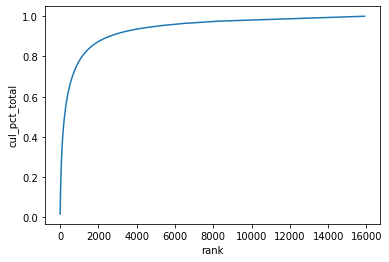

In [11]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

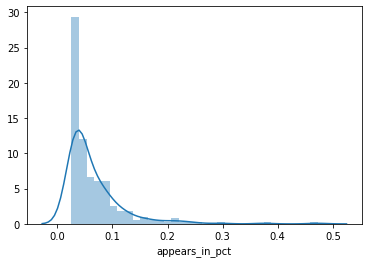

In [12]:
wc = wc[wc['appears_in_pct'] >= 0.025]

sns.distplot(wc['appears_in_pct']);

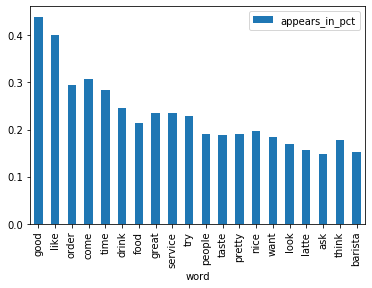

In [13]:
bad_coffee = count(shops[shops['star_rating']<=3]['tokens'])

bad_coffee[:20].plot.bar('word','appears_in_pct')
plt.show()

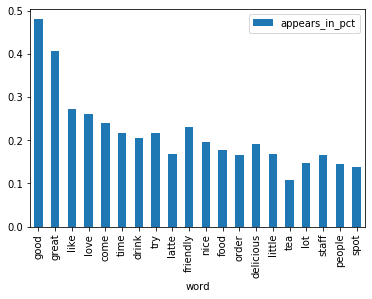

In [14]:
good_coffee = count(shops[shops['star_rating']>=4]['tokens'])

good_coffee[:20].plot.bar('word','appears_in_pct')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 



In [15]:
good_coffee.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
169,good,2949,4399,1.0,0.018025,0.018025,0.480293
92,great,2505,3474,2.0,0.014235,0.032261,0.407980
180,like,1668,2414,3.0,0.009892,0.042152,0.271661
7,love,1608,2120,4.0,0.008687,0.050839,0.261889
341,come,1479,1982,5.0,0.008121,0.058961,0.240879


In [31]:
good_vs_bad = pd.merge(good_coffee[['word','appears_in_pct']],
                       bad_coffee[['word','appears_in_pct']], 
                       how = 'inner', on = 'word')

columns = {'appears_in_pct_x':'good_pct', 'appears_in_pct_y':'bad_pct'}

good_vs_bad =  good_vs_bad.rename(columns = columns)

good_vs_bad.head()

,word,good_cpt,bad_cpt
0,good,0.480293,0.439024
1,great,0.407980,0.235772
2,like,0.271661,0.401084
3,love,0.261889,0.142276
4,come,0.240879,0.306233


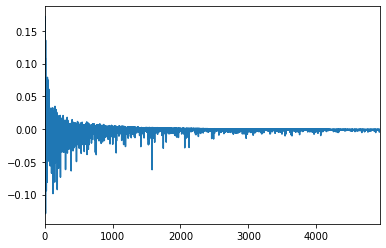

In [32]:
good_vs_bad['difference'] = good_vs_bad['good_pct'] - good_vs_bad['bad_pct']

good_vs_bad['difference'].plot()

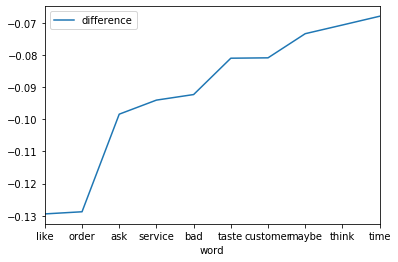

,word,difference
2,like,-0.129423
12,order,-0.128755
122,ask,-0.098400
24,service,-0.094026
185,bad,-0.092296
37,taste,-0.080992
147,customer,-0.080876
232,maybe,-0.073365
35,think,-0.070666
5,time,-0.067940


In [57]:
top_10_bad = good_vs_bad[['word', 'difference']].sort_values(by = 'difference')[:10]

top_10_bad.plot('word', 'difference')
plt.show()

top_10_bad

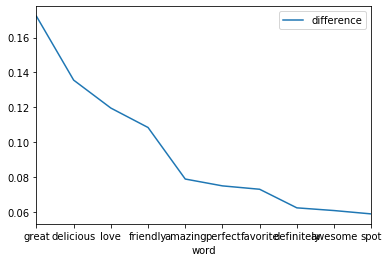

,word,difference
1,great,0.172208
13,delicious,0.135624
3,love,0.119613
9,friendly,0.108479
40,amazing,0.078958
47,perfect,0.075043
38,favorite,0.073102
20,definitely,0.062458
60,awesome,0.060906
19,spot,0.058979


In [55]:
top_10_good = good_vs_bad[['word', 'difference']].sort_values(by = 'difference', ascending = False)[:10]

top_10_good.plot('word', 'difference')
plt.show()

top_10_good

Still need to formalize analysis, but preliminary results are obvious when we look at the relative difference between words mentioned in reviews done on 'good' and 'bad' coffee shops. We can see that 'good' shops end up having more laudatory words, whereas the 'bad' shops show a pattern of words that can be interpreted as negative critiques against the establishment